# Assignment 7. Numerical Integration.

The assignment investigates different methods of solving the integral numerically. Particularly, the integral $$\int_{0}^{1}x^{10}(2-x)(1-e^{20(x-1)})dx$$ will be solved using several methods as trapezoidal rule, Romberg integration, adaptive quadrature and Gauss quadrature.

In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from scipy.integrate import quad

First, the function is defined as follows:

In [2]:
def f(x):
    return (x**10)*(2-x)*(1-np.exp(20*(x-1)))

Next, the true result of the integral between [0,1] is calculated:

In [3]:
true=float(quad(f, 0, 1)[0])

### 1) Trapezoid 

In [4]:
#calculates the integral using the trapezoidal rule with n segments
def trap(a,b,n):
    h = (b-a) / float(n)
    intgr = 0.5 * h * (f(a) + f(b))
    for i in range(1, int(n)):
        intgr = intgr + h * f(a+i * h)
    return intgr

1.66997293471e-06


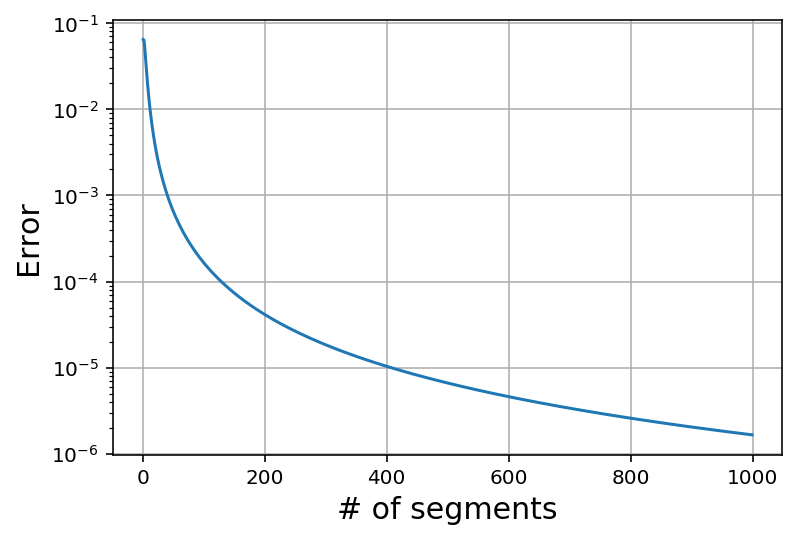

In [6]:
intg =[]
error=[]
n = np.arange(1, 1000)
for j in n:
    numerical = trap(0,1, j)
    ea=abs(trap(0,1,j)-quad(f, 0, 1)[0] )
    intg.append(numerical)
    error.append(ea)
    if(ea<1e-16):
        break        
    pres=min(error)    
print(pres)
plt.plot(n,error)
plt.legend()
plt.xlabel("# of segments", size=15) 
plt.ylabel("Error",size=15)
plt.yscale('log')
plt.grid()
plt.show()

From the above graph, we can see that the error decreases by $\frac{1}{n^2}$. Therefore it is inversely proportional to the square of n. However, the exact highest precision very much depends on the chosen value n, because it requires to divide into finitely many segments, so it may require a great computational effort and time. But, in this case when n was divided into 1000 segments, the highest precision is ~$10^{-6}$

### 2) Romberg Integration 

In [7]:
#it returns the value of the integral using Romberg integration through Richardson's extrapolation and Trapezoidal rule above
def romberg(a, b, n): 
    I = np.zeros((n, n))
    for k in range(0, n):
        #trapezoidal rule for 2^k segments
        I[k, 0]=trap(a,b,2**k) 
        #Recursive formula for Romberg
        for j in range(0, k):
            I[k,j+1]=(4**(j+1)*I[k,j]-I[k-1, j])/(4**(j+1)-1)          
            
        #print(I[k,0:k+1]) 
    return I     

The highest precision was calculated as follows below. And it was equal to ~$10^{-15}$

In [10]:
intg =[]
error=[]
n=10
for j in range(0,n):    
    I = romberg( 0, 1, n)
    #solution = I[n-1, n-1]    
    ea=abs(I[j-1,j-1]-quad(f, 0, 1)[0])    
    error.append(ea)
    if(ea<1e-16):
        break        
    pres=min(error)    
print(pres)         

1.33226762955e-15


### 3) Adaptive Quadrature 

In [11]:
#recursive adaptive function
def qstep(a,b,tol,fa,fc,fb):
    #initialization
    h1=b-a
    h2=h1/2
    c=(a+b)/2
    fd=f((a+c)/2)
    fe=f((c+b)/2)
    I1=h1/6*(fa+4*fc+fb)   #Simpson's 1/3 rule
    I2=h2/6*(fa+4*fd+2*fc+4*fe+fb)
    if(abs(I2-I1)<tol):  #terminates
        I=I2+(I2-I1)/15        
    else:                #recusion calls if needed
        Ia=qstep(a,c,tol,fa,fd,fc)
        Ib=qstep(c,b,tol,fc,fe,fb)
        I=Ia+Ib   
    return I
#main adaptive quadrature function which returns value of the integral
def quadapt(a,b):
    #initialization
    tol=1e-16
    c=(a+b)/2
    fa=f(a)
    fc=f(c)
    fb=f(b)
    quadapt=qstep(a,b,tol,fa,fc,fb)    
    return quadapt

Below is the highest precision that can be achieved with adaptive quadrature: ~$10^{-16}$

In [12]:
pres=print(abs(qstep(0,1,1e-16,f(0),f(0.5),f(1))-quad(f, 0, 1)[0])/quad(f, 0, 1)[0])  #returns precison

2.1528693609e-16


### 4) Gauss Quadrature 

To find the integral using Gauss Quadrature, we use one particular method from that called Gauss-Legendre polynomials. Therefore, there is a need to solve those equations by method called Methods of Undetermined coefficients. The roots of Legendre polynomials were found using Newton's method. 

In [13]:
#returns the arguments of functions and factors for given n-points
def gaussxc(n):

    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3,4*n-1,n)/(4*n+2)
    x = np.cos(mt.pi*a+1/(8*n*n*np.tan(a)))

    # Find roots of Legendre polynomial using Newton's method
    e = 1e-16
    delta = 1.0
    while delta>e:
        p0 = np.ones(n,float)
        p1 = np.copy(x)
        for k in range(1,n):
            p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
        dp = (n+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x =x- dx
        delta = max(abs(dx))

    # Calculate the coefficients
    c = 2*(n+1)*(n+1)/(n*n*(1-x*x)*dp*dp)

    return x,c
#returns the value of the integral with n number of points(n-point Gauss-Legendre Formula)
def gauss(n,a,b):
    x,c = gaussxc(n)
    return 0.5*(b-a)*x+0.5*(b+a),0.5*(b-a)*c

1.5959455979e-15


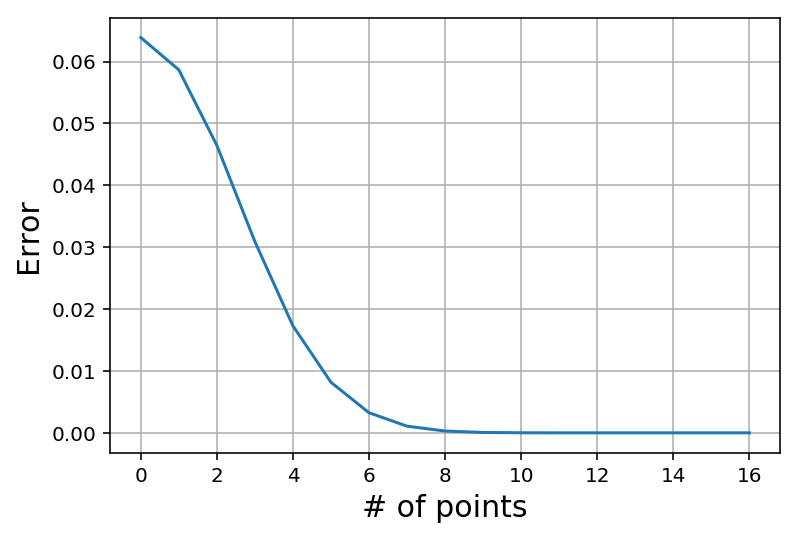

In [19]:
n = 20; a = 0.0; b = 1.0
xd,dxd = gaussxc(n)
x = 0.5*(b-a)*xd + 0.5*(b+a)
dx = 0.5*(b-a)*dxd
# Perform the integration
s = 0.0; intg=[]; error=[]
k=1; N=[]
for k in range(n):
    s += dx[k]*f(x[k])
    ea=abs(s-quad(f, 0, 1)[0])
    if(ea<1e-16):
        break
    error.append(ea)
    N.append(k)
    pres=min(error)
print(pres)
plt.plot(N,error)
plt.legend()
plt.xlabel("# of points", size=15) 
plt.ylabel("Error",size=15)
plt.grid()
plt.show()

From the above graph, we can see the dependance of error with number of points. The graph sugeests that higher-order formulas do not substantially increase the accuaracy of the value of the integral. The highest precision was around ~$10^{-15}$

In [24]:
%timeit trap(0,1,1000)

2.91 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit  romberg(0,1,10)

3.03 ms ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit quadapt(0,1)

32.5 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit gauss(10,0,n)

1.13 ms ± 48.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


                                                   Conclusion
Finally, the objectives of the experiment were achieved. The integral of the given function was calculated between given closed interval [0,1] using four methods mentioned above. Four different values of the integral were then compared with the actual value. Highest precisions for each of the methods were calculated. From above analysis, the following conlusions can be drawn:

1) Trapezoidal rule were actually slowest method since to require high accuracy it demands high computational effort. Moreover, trapezoidal rule is mostly suitable for nicely behaved functions. Finally, the round-off errors can limit ability to determine integrals. 

2) Romberg Integration is based on successive implementation of trapezoidal rule, therefore it is more efficient than trapezoidal rule. 

3) Adaptive Quadrature is more efficient than just Simpson's rule. This method solves the integral by adjusting the step size so that small intervals are used in regions of rapid variations and larger intervals in regions where the function changes gradually. 

4) Fourth method, Gauss Quadrature is based on solving Legendre polynomials using Method of Undetermined coefficients. 

Finally, it turns out that Gauss Quadrature was faster and computationally efficient. However, it is also important to note that efficiency depends on several factors such as behavior of function and values of functions. Also, usually more accurate methods are less stable than less accurate methods. 